### Triage Prediction: End-to-End Notebook

This notebook loads a realistic triage dataset, cleans and translates it to Somali, prevents data leakage, preprocesses features via pipelines, selects the top 20 χ² features, tunes an XGBoost classifier, and evaluates performance.

In [5]:
# Standard Library
from collections import Counter
from typing import List
import warnings

# Third-Party Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn - Data Preparation & Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer, LabelEncoder, OneHotEncoder,
    OrdinalEncoder, StandardScaler
)

# scikit-learn - Feature Selection
from sklearn.feature_selection import SelectKBest, chi2

# scikit-learn - Model Selection & Evaluation
from sklearn.model_selection import (
    GridSearchCV, KFold, cross_val_score, train_test_split
)
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    f1_score, precision_score, recall_score
)

# scikit-learn - Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier, BaggingClassifier,
    GradientBoostingClassifier, RandomForestClassifier
)

# XGBoost
from xgboost import XGBClassifier

# imbalanced-learn
from imblearn.over_sampling import SMOTE

# Reproducibility
RND = 42

# Ignore warnings
warnings.filterwarnings("ignore")

## 2. Load & Initial Cleaning

- Drop the English-label column  
- Rename all columns to their Somali equivalents  
- Shorten the Somali triage labels  
- Separate dashboard-only columns (`tirada_halista`, `talooyin`)

In [6]:
# 2.1 Load
df = pd.read_csv('../data/realistic_triage_dataset.csv')

# 2.2 Drop duplicate English triage column
df.drop('Triage_Level_EN', axis=1, inplace=True)

In [7]:
# 2.3 Rename to Somali
COLUMN_TRANSLATIONS = {
    'Age_Group': 'da\'da',
    'Has_Fever': 'qandho',
    'Has_Cough': 'qufac',
    'Has_Headache': 'madax_xanuun',
    'Has_Abdominal_Pain': 'caloosh_xanuun',
    'Has_Fatigue': 'daal',
    'Has_Vomiting': 'matag',
    'Fever_Level': 'heerka_qandhada',
    'Fever_Duration_Level': 'muddada_qandhada',
    'Chills': 'dhaxan',
    'Cough_Type': 'nooca_qufaca',
    'Cough_Duration_Level': 'muddada_qufaca',
    'Blood_Cough': 'qufac_dhiig',
    'Breath_Difficulty': 'neeftu_dhibto',
    'Headache_Severity': 'madax_xanuun_daran',
    'Headache_Duration_Level': 'muddada_madax_xanuunka',
    'Photophobia': 'iftiinka_dhibayo',
    'Neck_Stiffness': 'qoortu_adag_tahay',
    'Pain_Location': 'halka_xanuunku_kaa_hayo',
    'Pain_Duration_Level': 'muddada_xanuunka',
    'Nausea': 'lalabo',
    'Diarrhea': 'shuban',
    'Fatigue_Severity': 'daal_badan',
    'Fatigue_Duration_Level': 'muddada_daalka',
    'Weight_Loss': 'miisankaga_isdhimay',
    'Fever_With_Fatigue': 'qandho_daal_leh',
    'Vomiting_Severity': 'matag_daran',
    'Vomiting_Duration_Level': 'muddada_mataga',
    'Blood_Vomit': 'matag_dhiig_leh',
    'Unable_To_Keep_Fluids': 'ceshan_karin_qoyaanka',
    'Red_Flag_Count': 'tirada_halista',
    'Triage_Level_SO': 'xaaladda_bukaanka',
    'Tips_SO': 'talooyin'
}
df = df.rename(columns=COLUMN_TRANSLATIONS)

# 2.4 Shorten triage labels
TRIAGE_MAP = {
    "Xaalad dhax dhaxaad eh (Bukaan socod)": "bukaan socod",
    "Xaalad fudud (Daryeel guri)":     "daryeel guri",
    "Xaalad deg deg ah":               "xaalad deg-deg ah"
}
df['xaaladda_bukaanka'] = df['xaaladda_bukaanka'].map(TRIAGE_MAP)

# 2.5 Separate dashboard-only columns
dashboard_info = df[['tirada_halista','talooyin','xaaladda_bukaanka']].copy()

# 2.6 Drop leakage columns from modeling DataFrame
df_ml = df.drop(columns=['tirada_halista','talooyin'])

In [8]:
df_ml.head()

,da'da,qandho,qufac,madax_xanuun,caloosh_xanuun,daal,matag,heerka_qandhada,muddada_qandhada,dhaxan,...,shuban,daal_badan,muddada_daalka,miisankaga_isdhimay,qandho_daal_leh,matag_daran,muddada_mataga,matag_dhiig_leh,ceshan_karin_qoyaanka,xaaladda_bukaanka
0,child,1,1,0,0,0,0,high,moderate,yes,...,no,NaN,NaN,no,no,NaN,NaN,no,no,xaalad deg-deg ah
1,adult,0,1,0,0,0,0,NaN,NaN,no,...,no,NaN,NaN,no,yes,NaN,NaN,yes,yes,daryeel guri
2,elderly,0,0,0,0,1,0,NaN,NaN,no,...,yes,NaN,mild,no,no,high,NaN,no,no,bukaan socod
3,child,0,0,0,0,1,0,NaN,NaN,no,...,no,mild,mild,no,no,NaN,NaN,no,no,xaalad deg-deg ah
4,adult,1,1,0,0,0,1,high,moderate,yes,...,no,NaN,NaN,no,yes,high,high,yes,yes,xaalad deg-deg ah


## 3. Quick EDA & Value Counts

In [9]:
# %%
for col in df_ml.columns:
    print(f"\n{col}")
    print(df_ml[col].value_counts(dropna=False).head())


da'da
da'da
adult      15985
child       8114
elderly     5901
Name: count, dtype: int64

qandho
qandho
0    16050
1    13950
Name: count, dtype: int64

qufac
qufac
0    17428
1    12572
Name: count, dtype: int64

madax_xanuun
madax_xanuun
0    17510
1    12490
Name: count, dtype: int64

caloosh_xanuun
caloosh_xanuun
0    20362
1     9638
Name: count, dtype: int64

daal
daal
0    20491
1     9509
Name: count, dtype: int64

matag
matag
0    20336
1     9664
Name: count, dtype: int64

heerka_qandhada
heerka_qandhada
NaN         13890
moderate     6910
high         5309
mild         3891
Name: count, dtype: int64

muddada_qandhada
muddada_qandhada
NaN         13918
moderate     8779
mild         3845
high         3458
Name: count, dtype: int64

dhaxan
dhaxan
no     20303
yes     9697
Name: count, dtype: int64

nooca_qufaca
nooca_qufaca
NaN    15622
dry     7306
wet     7072
Name: count, dtype: int64

muddada_qufaca
muddada_qufaca
NaN         14989
moderate     7132
high         3998
mild

## 4. Train/Test Split & Stratification

- Encode the target for stratification  
- Perform a stratified split  

In [10]:
# 4.1 Features & target
X = df_ml.drop('xaaladda_bukaanka', axis=1)
y = df_ml['xaaladda_bukaanka']

# 4.2 Label-encode target
le = LabelEncoder()
y_enc = le.fit_transform(y)

# 4.3 Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc,
    test_size=0.2, random_state=RND,
    stratify=y_enc
)

# 4.4 Check distributions
def print_dist(arr, name):
    cnts = Counter(arr)
    total = len(arr)
    print(f"\n{name} distribution:")
    for lbl, ct in cnts.items():
        print(f"  {le.inverse_transform([lbl])[0]:<20} {ct:>4} ({ct/total*100:>5.1f}%)")

print_dist(y_train, "Train")
print_dist(y_test,  "Test")


Train distribution:
  xaalad deg-deg ah    4602 ( 19.2%)
  daryeel guri         7442 ( 31.0%)
  bukaan socod         11956 ( 49.8%)

Test distribution:
  bukaan socod         2989 ( 49.8%)
  daryeel guri         1861 ( 31.0%)
  xaalad deg-deg ah    1150 ( 19.2%)


## 5. Preprocessing Pipelines

- **Ordinal features**: fill `'0'` or missing with most frequent, then map `['mild','moderate','high']` → `[0,1,2]`  
- **Binary features**: pass through (already 0/1)  
- **Nominal features**: fill `'0'` with most frequent, then one-hot encode (drop first)


In [11]:
from imblearn.pipeline import Pipeline as ImbPipeline


# --- Feature groups
ordinal_feats = [
    'heerka_qandhada','muddada_qandhada',
    'madax_xanuun_daran','muddada_madax_xanuunka',
    'muddada_qufaca','muddada_xanuunka',
    'muddada_daalka','muddada_mataga',
    'daal_badan','matag_daran'
]
binary_feats = [
    'qandho','qufac','madax_xanuun','caloosh_xanuun','daal','matag',
    'dhaxan','qufac_dhiig','neeftu_dhibto','iftiinka_dhibayo',
    'qoortu_adag_tahay','lalabo','shuban','miisankaga_isdhimay',
    'qandho_daal_leh','matag_dhiig_leh','ceshan_karin_qoyaanka'
]
nominal_feats = ["da'da", "nooca_qufaca", "halka_xanuunku_kaa_hayo"]

# --- Replace Somali/English yes/no
binary_map = {
    'haa': 1, 'yes': 1, '1': 1,
    'maya': 0, 'no': 0, '0': 0
}
for df_ in (X_train, X_test):
    for col in ordinal_feats + nominal_feats + binary_feats:
        df_[col] = df_[col].astype(str)
    df_[binary_feats] = df_[binary_feats].replace(binary_map)

# --- Handle '0' or 'nan' strings
replace_str_nan = FunctionTransformer(
    lambda X: np.where((X == '0') | (X == 'nan'), np.nan, X),
    validate=False
)

# --- Preprocessing pipelines
ord_pipe = Pipeline([
    ('to_nan', replace_str_nan),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=[['mild','moderate','high']] * len(ordinal_feats)))
])

bin_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

nom_pipe = Pipeline([
    ('to_nan', replace_str_nan),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])

# --- Column-wise preprocessing
preprocessor = ColumnTransformer([
    ('ord', ord_pipe, ordinal_feats),
    ('bin', bin_pipe, binary_feats),
    ('nom', nom_pipe, nominal_feats)
])

# Step 1: Preprocess X_train and X_test
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [12]:
# Step 2: Apply SMOTE separately
smote = SMOTE(random_state=RND)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

# ✅ Done
print("✅ After SMOTE:", X_train_resampled.shape, y_train_resampled.shape)
print("✅ Test set shape:", X_test_transformed.shape)

  File "c:\Users\maqbu\miniconda3\envs\ds_env\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\maqbu\miniconda3\envs\ds_env\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\maqbu\miniconda3\envs\ds_env\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\maqbu\miniconda3\envs\ds_env\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


✅ After SMOTE: (35868, 32) (35868,)
✅ Test set shape: (6000, 32)


In [13]:
# Check class distribution
unique, counts = np.unique(y_train_resampled, return_counts=True)
print("✅ Class distribution after RandomOverSampler:")
for cls, count in zip(unique, counts):
    print(f"   Class {cls}: {count} samples")

# Optional: Check original class distribution for comparison
print("\n📊 Original class distribution:")
unique_orig, counts_orig = np.unique(y_train, return_counts=True)
for cls, count in zip(unique_orig, counts_orig):
    print(f"   Class {cls}: {count} samples")

✅ Class distribution after RandomOverSampler:
   Class 0: 11956 samples
   Class 1: 11956 samples
   Class 2: 11956 samples

📊 Original class distribution:
   Class 0: 11956 samples
   Class 1: 7442 samples
   Class 2: 4602 samples


## 6. Modeling Pipeline & Feature Selection

- Preprocess → SelectKBest(χ², k=20)

In [14]:
selector = SelectKBest(score_func=chi2, k=20)
X_train_sel = selector.fit_transform(X_train_resampled, y_train_resampled)
X_test_sel = selector.transform(X_test_transformed)

## 7. Classifier Cross-Validation

Compare a slate of baseline classifiers via 10-fold CV.

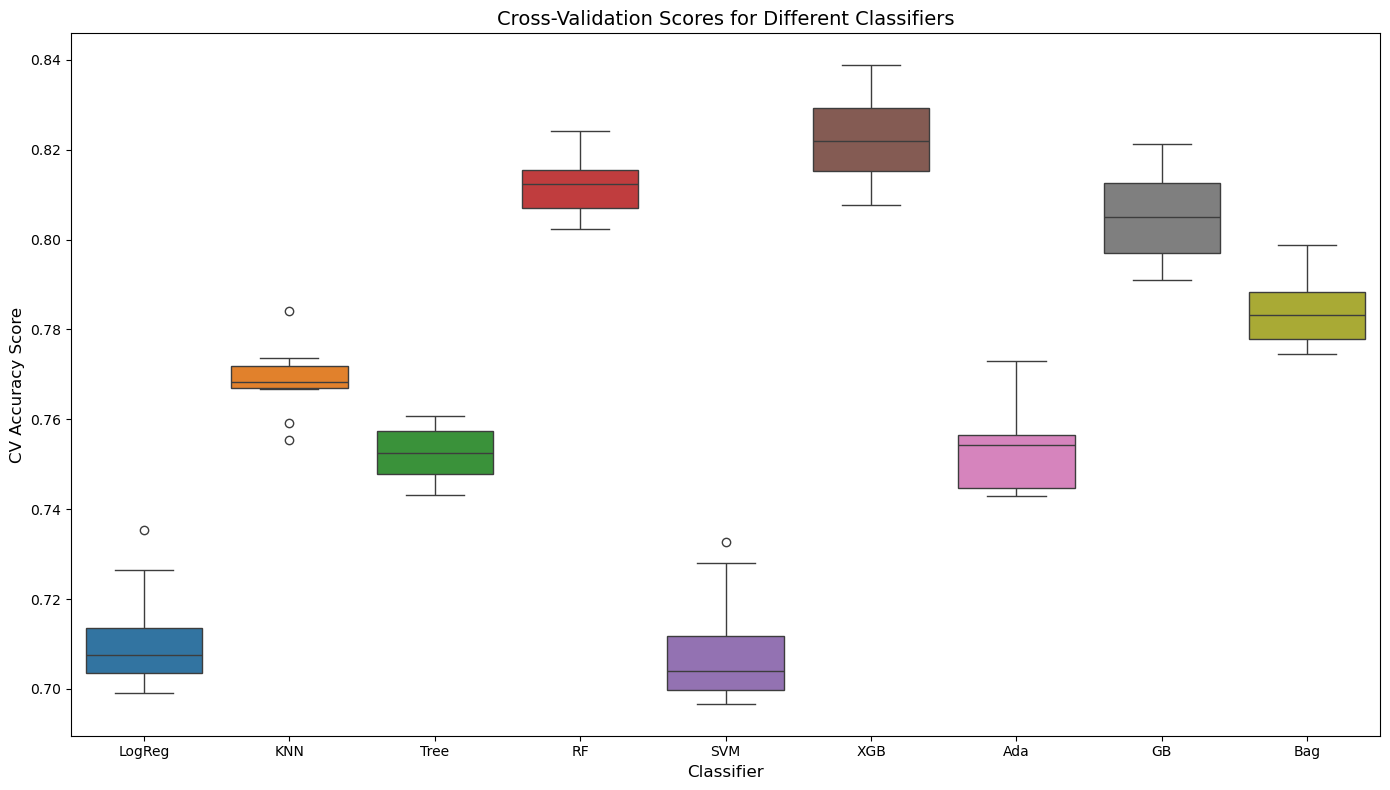

,Mean,±2 std
XGB,0.822210,0.018349
RF,0.812340,0.013401
GB,0.804924,0.019576
Bag,0.784293,0.016292
KNN,0.768541,0.014849
Ada,0.753653,0.018783
Tree,0.752287,0.012148
LogReg,0.711164,0.022222
SVM,0.708655,0.023909


In [15]:
# Classifiers
clfs = [
    ('LogReg', LogisticRegression(solver='liblinear', max_iter=2000)),
    ('KNN',    KNeighborsClassifier()),
    ('Tree',   DecisionTreeClassifier()),
    ('RF',     RandomForestClassifier(random_state=RND)),
    ('SVM',    LinearSVC(random_state=RND, max_iter=2000)),
    ('XGB',    XGBClassifier(random_state=RND, eval_metric='mlogloss')),
    ('Ada',    AdaBoostClassifier(random_state=RND)),
    ('GB',     GradientBoostingClassifier(random_state=RND)),
    ('Bag',    BaggingClassifier(random_state=RND)),
]

# Cross-validation setup
kf = KFold(n_splits=10, shuffle=True, random_state=RND)
results = {
    name: cross_val_score(clf, X_train_sel, y_train_resampled, cv=kf, scoring='accuracy')
    for name, clf in clfs
}

# Plot cross-validation scores using seaborn
cv_scores_df = pd.DataFrame(results)
plt.figure(figsize=(14, 8))
sns.boxplot(data=cv_scores_df)
plt.xlabel('Classifier', fontsize=12)
plt.ylabel('CV Accuracy Score', fontsize=12)
plt.title('Cross-Validation Scores for Different Classifiers', fontsize=14)
# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output mean scores
mean_scores = {
    name: (scores.mean(), scores.std() * 2)
    for name, scores in results.items()
}
mean_scores_df = pd.DataFrame(mean_scores, index=['Mean', '±2 std']).T
mean_scores_df = mean_scores_df.sort_values('Mean', ascending=False)
mean_scores_df

## 8. Hyperparameter Tuning: XGBoost via GridSearchCV

Use weighted-F1 as the scorer.

In [29]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

# Define scoring function
scorer = make_scorer(f1_score, average='weighted')

# Define parameter grid for XGBoost tuning
xgb_param_dist = {
    'n_estimators': np.arange(250, 400, 25),             # More trees for lower learning rate
    'max_depth': [4, 5, 6, 7, 8, 9],                     # Include 4 for shallower trees
    'learning_rate': np.linspace(0.01, 0.08, 8),         # Lower values for more stable learning
    'subsample': np.linspace(0.5, 0.9, 5),               # Wider subsampling range
    'colsample_bytree': np.linspace(0.5, 0.9, 5),        # Same here
    'gamma': np.linspace(0, 0.4, 5),                     # Gamma regularization
    'min_child_weight': [1, 5, 10, 15, 20],              # Include smaller values for flexibility
    'reg_alpha': [0, 0.5, 1, 1.5],                       # L1 regularization
    'reg_lambda': [1, 1.5, 2, 3]                         # L2 regularization
}

# Initialize base model
xgb_model = XGBClassifier(
    objective='multi:softprob' if len(np.unique(y_train_resampled)) > 2 else 'binary:logistic',
    eval_metric='mlogloss' if len(np.unique(y_train_resampled)) > 2 else 'logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_dist,
    n_iter=50,
    scoring=scorer,
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

print("Starting RandomizedSearchCV...")
random_search.fit(X_train_sel, y_train_resampled)

Starting RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learnin...
                                        'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]),
                                        'max_depth': [4, 5, 6, 7, 8, 9],
                                        'min_child_weight': [1, 5, 10, 15, 20],
                                        'n_estimators': array([250, 275, 300, 325, 350, 375]),
                                        'reg_alpha': [0, 0.5, 1, 1.5],
                                        'reg_lambda': [1, 1.5, 2, 3],
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict', average=weighted),
                   verbose=1)

In [ ]:
# Print the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", random_search.best_score_)

Starting RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 0.5, 'n_estimators': 325, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.08, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best cross-validation score:  0.8172260020924211


In [39]:
print(f"XGBoost model score (default hyperparameters): {np.mean(list(results.values())) * 100:.2f}%")
print(f"XGBoost model score (tuned hyperparameters): {random_search.best_score_ * 100:.2f}%")

XGBoost model score (default hyperparameters): 76.87%
XGBoost model score (tuned hyperparameters): 81.72%


### Using the Best parameters found in the RandomSearchCV:

In [37]:
best_params = {
    'subsample': 0.9,
    'reg_lambda': 2,
    'reg_alpha': 0.5,
    'n_estimators': 325,
    'min_child_weight': 5,
    'max_depth': 8,
    'learning_rate': 0.08,
    'gamma': 0.1,
    'colsample_bytree': 0.8
}

final_model = XGBClassifier(
    **best_params,
    objective='multi:softprob' if len(np.unique(y_train_resampled)) > 2 else 'binary:logistic',
    eval_metric='mlogloss' if len(np.unique(y_train_resampled)) > 2 else 'logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

final_model.fit(X_train_sel, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.08, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=325,
              n_jobs=-1, num_parallel_tree=None, objective='multi:softprob', ...)

In [38]:
from sklearn.metrics import classification_report

y_pred = final_model.predict(X_test_sel)  # Make sure X_test_sel is preprocessed like X_train_sel
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      2989
           1       0.78      0.77      0.78      1861
           2       0.81      0.61      0.69      1150

    accuracy                           0.80      6000
   macro avg       0.80      0.76      0.77      6000
weighted avg       0.80      0.80      0.80      6000



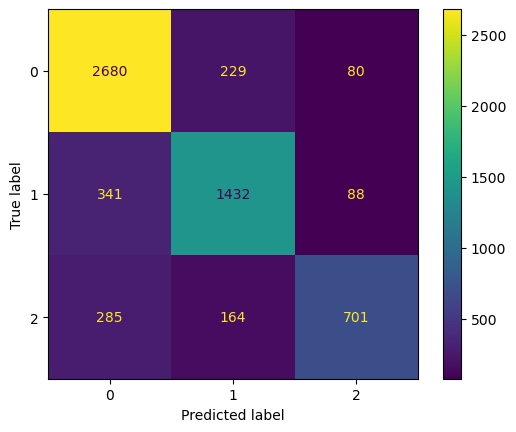

In [40]:
# If predicted on validation set
y_pred = final_model.predict(X_test_sel)

# Then compute and display
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### GridSearchCV

In [43]:
from sklearn.model_selection import StratifiedKFold

sample_frac = 0.2
n_samples = int(len(X_train_sel) * sample_frac)
np.random.seed(42)
indices = np.random.choice(len(X_train_sel), size=n_samples, replace=False)
X_tune = X_train_sel[indices]
y_tune = y_train_resampled[indices]  # or y_train_resampled.loc[indices] if Pandas Series

# Define scoring metric
scorer = make_scorer(f1_score, average='weighted')

# Narrowed parameter grid
param_grid = {
    'n_estimators': [250, 300],       # fewer options
    'max_depth': [5, 7],
    'learning_rate': [0.03, 0.05],
    'min_child_weight': [5],
    'subsample': [0.7, 0.85],
    'colsample_bytree': [0.6, 0.8],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 0.5],
    'reg_lambda': [1]
}

# Initialize model
xgb = XGBClassifier(
    objective='multi:softprob' if len(np.unique(y_train_resampled)) > 2 else 'binary:logistic',
    eval_metric='mlogloss' if len(np.unique(y_train_resampled)) > 2 else 'logloss',
    use_label_encoder=False,
    n_jobs=-1,
    random_state=42
)

# Stratified CV with fewer splits
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=scorer,
    n_jobs=-1,
    cv=cv,
    verbose=1
)

# Early stopping parameters
fit_params = {
    "eval_set": [(X_tune, y_tune)],
    "early_stopping_rounds": 10,
    "verbose": False
}

# Run tuning
print("Starting GridSearchCV on sample...")
grid_search.fit(
    X_tune,
    y_tune,
    **fit_params
)

print("Starting GridSearchCV...")
grid_search.fit(X_train_sel, y_train_resampled)

Starting GridSearchCV on sample...
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Starting GridSearchCV...
Fitting 3 folds for each of 128 candidates, totalling 384 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importan...
                                     n_jobs=-1, num_parallel_tree=None,
                                     objective='multi:softprob', ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8], 'gamma': [0, 0.1],
                         'learning_rate': [0.03, 0.05], 'max_depth': [5, 7],
                         'min_child_weight': [5], 'n_estimators': [250, 300],
                         'reg_alpha': [0, 0.5], 'reg_lambda': [1],
                         'subsample': [0.7, 0.85]},
             scoring=make_scorer(f1_score, response_method='predict', average=weighted),
             verbose=1)

In [44]:
print("Best Parameters:", grid_search.best_params_)
print(f"Best CV Score: {grid_search.best_score_ * 100:.2f}%")

Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.7}
Best CV Score: 82.12%


In [45]:
final_model = XGBClassifier(
    **grid_search.best_params_,
    objective='multi:softprob' if len(np.unique(y_train_resampled)) > 2 else 'binary:logistic',
    eval_metric='mlogloss' if len(np.unique(y_train_resampled)) > 2 else 'logloss',
    use_label_encoder=False,
    n_jobs=-1,
    random_state=42
)

final_model.fit(X_train_sel, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_parallel_tree=None, objective='multi:softprob', ...)

In [46]:
from sklearn.metrics import classification_report

y_pred = final_model.predict(X_test_sel)  # Make sure X_test_sel is preprocessed like X_train_sel
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      2989
           1       0.79      0.78      0.78      1861
           2       0.81      0.62      0.70      1150

    accuracy                           0.81      6000
   macro avg       0.81      0.76      0.78      6000
weighted avg       0.81      0.81      0.80      6000



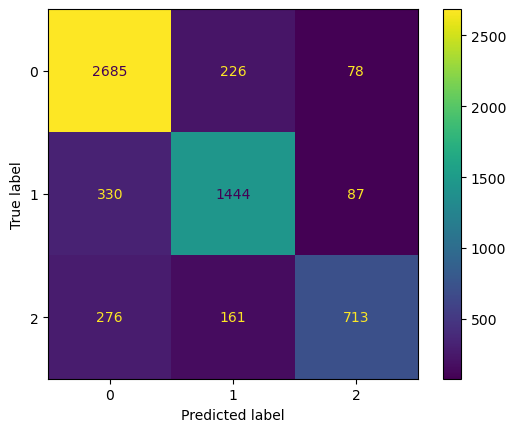

In [47]:
# If predicted on validation set
y_pred = final_model.predict(X_test_sel)

# Then compute and display
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## 9. Final Evaluation on Test Set

Test F1 (weighted): 0.8033738737266203


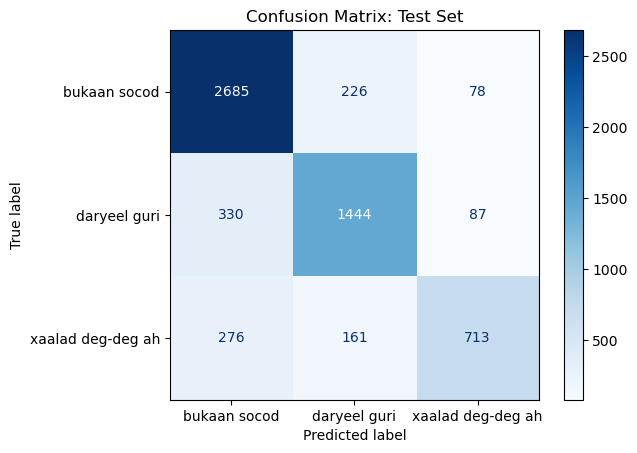

In [51]:
# best = random_search.best_estimator_
y_pred = final_model.predict(X_test_sel)

print("Test F1 (weighted):", f1_score(y_test, y_pred, average='weighted'))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: Test Set")
plt.show()

In [53]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

# Train Random Forest model (assuming X_train_sel and y_train_resampled exist)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_sel, y_train_resampled)

# Get feature names after preprocessing
def get_feature_names(preprocessor):
    ord_names = ordinal_feats
    bin_names = binary_feats
    
    # Get nominal one-hot encoded feature names
    nom_encoder = preprocessor.named_transformers_['nom'].named_steps['onehot']
    nom_imputer = preprocessor.named_transformers_['nom'].named_steps['imputer']
    nom_cols = nom_imputer.feature_names_in_
    nom_onehot_names = nom_encoder.get_feature_names_out(nom_cols).tolist()
    
    return ord_names + bin_names + nom_onehot_names

feature_names = get_feature_names(preprocessor)
X_test_df = pd.DataFrame(X_test_sel, columns=feature_names)

# Compute SHAP values using TreeExplainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_df)

# Prepare SHAP summary dataframe for seaborn plots
shap_df = pd.DataFrame(shap_values[1], columns=feature_names)
shap_means = shap_df.abs().mean().sort_values(ascending=False)
top_features = shap_means.head(20).index
shap_df_top = shap_df[top_features]

# Create SHAP seaborn plots
plt.figure(figsize=(12, 6))
sns.barplot(x=shap_means[top_features], y=top_features)
plt.title("Top 20 Feature Importances (SHAP)")
plt.xlabel("Mean Absolute SHAP Value")
plt.tight_layout()
plt.show()

# SHAP boxplot (distribution of SHAP values)
plt.figure(figsize=(12, 6))
sns.boxplot(data=shap_df_top, orient="h", fliersize=2)
plt.title("SHAP Value Distribution for Top 20 Features")
plt.xlabel("SHAP Value")
plt.tight_layout()
plt.show()

# SHAP violinplot for deeper distribution insight
plt.figure(figsize=(12, 6))
sns.violinplot(data=shap_df_top, orient="h", inner="quartile", scale="width")
plt.title("SHAP Violin Plot (Top 20 Features)")
plt.xlabel("SHAP Value")
plt.tight_layout()
plt.show()

# Evaluation metrics
y_pred = rf_model.predict(X_test_sel)
y_proba = rf_model.predict_proba(X_test_sel)[:, 1]

eval_metrics = {
    "Model": ["RandomForest"],
    "Accuracy": [accuracy_score(y_test, y_pred)],
    "Precision": [precision_score(y_test, y_pred)],
    "Recall": [recall_score(y_test, y_pred)],
    "F1 Score": [f1_score(y_test, y_pred)],
    "ROC AUC": [roc_auc_score(y_test, y_proba)]
}

eval_df = pd.DataFrame(eval_metrics)
eval_df.set_index("Model", inplace=True)

# Plot evaluation metrics
plt.figure(figsize=(10, 5))
eval_df.T.plot(kind="bar", legend=True, figsize=(10, 6))
plt.title("Model Evaluation Metrics Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


AttributeError: 'SimpleImputer' object has no attribute 'feature_names_in_'

## 10. Save Dashboard-Only Info & Model

In [ ]:
# %%
dashboard_train = dashboard_info.loc[X_train.index]
dashboard_test  = dashboard_info.loc[X_test.index]

# Optional: save for downstream use
# dashboard_train.to_csv('dashboard_train.csv', index=False)
# dashboard_test.to_csv('dashboard_test.csv', index=False)
import joblib
joblib.dump(best, 'xgb_triage_model.joblib')
